In [ ]:
"""
Brendan Lauterborn
ALS Matrix Factorization for Movie Recommendations
Data Citation:
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context.
ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.
https://doi.org/10.1145/2827872
"""

!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

!apt-get install -y build-essential cmake python3-dev
!pip install --no-cache-dir implicit

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.model_selection import train_test_split
import implicit


ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
movies  = pd.read_csv("ml-latest-small/movies.csv")

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

from scipy.sparse import coo_matrix



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  2801k      0 --:--:-- --:--:-- --:--:-- 2809k
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
python3-dev is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [ ]:
user_map = {u: i for i, u in enumerate(ratings_df['userId'].unique())}
item_map = {m: i for i, m in enumerate(ratings_df['movieId'].unique())}

rows = ratings_df['userId'].map(user_map)
cols = ratings_df['movieId'].map(item_map)
vals = ratings_df['rating']


# Encode IDs as indices
# Training matrix
rows_train = train_df['userId'].map(user_map)
cols_train = train_df['movieId'].map(item_map)
vals_train = train_df['rating']
Ui_train = coo_matrix((vals_train, (rows_train, cols_train)),
                      shape=(len(user_map), len(item_map)))

# Test matrix
rows_test = test_df['userId'].map(user_map)
cols_test = test_df['movieId'].map(item_map)
vals_test = test_df['rating']
Ui_test = coo_matrix((vals_test, (rows_test, cols_test)),
                     shape=(len(user_map), len(item_map)))

# Create sparse user-item matrix
user_item = coo_matrix((vals, (rows, cols)))

user_item.shape

(610, 9724)

In [ ]:
from implicit.als import AlternatingLeastSquares
# Convert to confidence weigts
alpha = 15
confidence = (user_item * alpha).astype('double')

# Train the model
model = AlternatingLeastSquares(
    factors=20,
    regularization=0.1,
    iterations=20,
    random_state=42
)
model.fit(confidence)


/usr/local/lib/python3.12/dist-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009867668151855469 seconds
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
# Convert to CSR for fast row access
confidence_csr = confidence.tocsr()

user_id = 0
recommended = model.recommend(user_id, confidence_csr[user_id])


In [ ]:
import numpy as np

def precision_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    precisions = []
    for user in range(train_user_items.shape[0]):
        # skip cold-start / empty rows in train
        if train_user_items[user].nnz == 0:
            continue
        test_items = test_user_items[user].indices
        if len(test_items) == 0:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        hits = len(set(rec_ids) & set(test_items))
        precisions.append(hits / K)
    return np.mean(precisions) if len(precisions) else 0.0

def recall_at_k(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    recalls = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = test_user_items[user].indices
        if len(test_items) == 0:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        hits = len(set(rec_ids) & set(test_items))
        recalls.append(hits / len(test_items))
    return np.mean(recalls) if len(recalls) else 0.0
def map_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items = test_user_items.tocsr()
    maps = []

    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = set(test_user_items[user].indices)
        if len(test_items) == 0:
            continue

        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )

        hits = 0
        precisions = []
        for i, rec in enumerate(rec_ids):
            if rec in test_items:
                hits += 1
                precisions.append(hits / (i + 1))
        if precisions:
            maps.append(np.mean(precisions))
        else:
            maps.append(0.0)
    return np.mean(maps) if maps else 0.0

def ndcg_at_k_manual(model, train_user_items, test_user_items, K=10):
    train_user_items = train_user_items.tocsr()
    test_user_items  = test_user_items.tocsr()
    ndcgs = []
    for user in range(train_user_items.shape[0]):
        if train_user_items[user].nnz == 0:
            continue
        test_items = set(test_user_items[user].indices)
        if len(test_items) == 0:
            continue
        rec_ids, _ = model.recommend(
            user,
            train_user_items[user],
            N=K,
            filter_already_liked_items=True
        )
        # DCG
        dcg = 0.0
        for i, rec in enumerate(rec_ids):
            if rec in test_items:
                dcg += 1.0 / np.log2(i + 2.0)
        # IDCG (best possible DCG given |test_items|)
        idcg = sum(1.0 / np.log2(i + 2.0) for i in range(min(len(test_items), K)))
        ndcgs.append(dcg / idcg if idcg > 0 else 0.0)
    return np.mean(ndcgs) if len(ndcgs) else 0.0

#Evaluate
K_values = [5, 10, 20]
results = []

for K in K_values:
    precision = precision_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    recall = recall_at_k(model, Ui_train_csr, Ui_test_csr, K)
    mapk = map_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    ndcg = ndcg_at_k_manual(model, Ui_train_csr, Ui_test_csr, K)
    results.append({
        "K": K,
        "Precision": precision,
        "Recall": recall,
        "MAP": mapk,
        "NDCG": ndcg
    })
metrics_df = pd.DataFrame(results)
display(metrics_df)

,K,Precision,Recall,MAP,NDCG
0,5,0.142623,0.076675,0.232755,0.145102
1,10,0.140328,0.139353,0.240717,0.162267
2,20,0.133607,0.238532,0.233050,0.202975


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['K'].plot(kind='hist', bins=20, title='K')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Precision'].plot(kind='hist', bins=20, title='Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Recall'].plot(kind='hist', bins=20, title='Recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='K', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='K', y='Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Precision', y='Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Recall', y='MAP', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['MAP']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('MAP')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['K']
  ys = series['Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('K', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('K')
_ = plt.ylabel('Precision')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['K'].plot(kind='line', figsize=(8, 4), title='K')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Precision'].plot(kind='line', figsize=(8, 4), title='Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Recall'].plot(kind='line', figsize=(8, 4), title='Recall')
plt.gca().spines[['top', 'right']].set_visible(False)

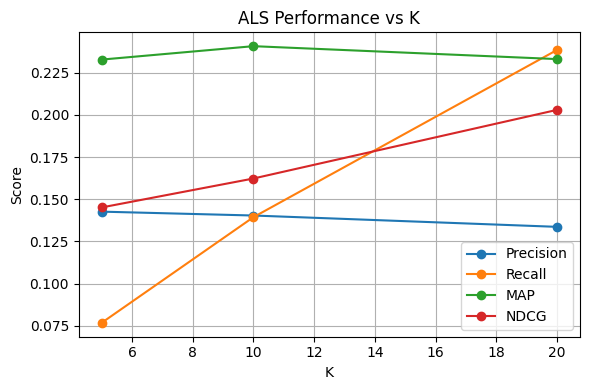

In [ ]:
import matplotlib.pyplot as plt

# Line chart of all metrics vs K
fig = plt.figure(figsize=(6,4))
for col in ["Precision", "Recall", "MAP", "NDCG"]:
    plt.plot(metrics_df["K"], metrics_df[col], marker="o", label=col)

plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS Performance vs K")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




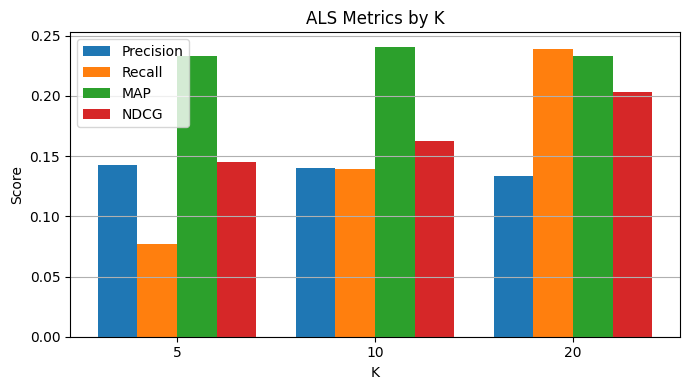

In [ ]:
import numpy as np
labels = metrics_df["K"].astype(str).tolist()
x = np.arange(len(labels))
width = 0.2

fig = plt.figure(figsize=(7,4))
plt.bar(x - 1.5*width, metrics_df["Precision"], width, label="Precision")
plt.bar(x - 0.5*width, metrics_df["Recall"],    width, label="Recall")
plt.bar(x + 0.5*width, metrics_df["MAP"],       width, label="MAP")
plt.bar(x + 1.5*width, metrics_df["NDCG"],      width, label="NDCG")

plt.xticks(x, labels)
plt.xlabel("K")
plt.ylabel("Score")
plt.title("ALS Metrics by K")
plt.grid(axis="y")
plt.legend()
plt.tight_layout()
plt.show()
